In [18]:
%matplotlib widget
import os

import numpy as np
import pandas as pd
import scipy as sp
import open3d as o3d
import skimage
import sklearn
import matplotlib.pyplot as plt

import dicom

In [73]:
from needle_reconstruction_ct import (
    ROI3D,
    CTNeedleReconstruction,
    CTNeedleReconstructionOptions,
)
from stereo_needle_proc import (
    arclength,
    axisEqual3D,
)
from util import BSplineND, transformSE3, point_cloud_registration

In [3]:
# test processing
def reconstruct_needle(ct_nr, **kwargs):
    retval = dict()
    thresh_mask = ct_nr.dicom_image3d.image >= ct_nr.options.threshold
    roi_mask    = ct_nr.options.roi.get_mask(thresh_mask.shape, invert=False)
    bo_mask     = np.ones_like(roi_mask)
    for bor in ct_nr.options.blackout_regions:
        break
        bo_mask  &= bor.get_mask(
            thresh_mask.shape, 
            invert=True,
        )

    # for

    seg_mask = thresh_mask & roi_mask & bo_mask

    # segment needle
    seg_needle_mask = seg_mask & ct_nr.options.roi_needle.get_mask(seg_mask.shape, invert=False)
    for bor in ct_nr.options.blackout_regions_needle:
        seg_needle_mask &= bor.get_mask(
            seg_needle_mask.shape,
            invert=True
        )

    # for

    retval['needle_mask'] = seg_needle_mask

    count_thresh = 500
    lbl_needle_mask, num_labels = skimage.measure.label(
        seg_needle_mask,
        connectivity=kwargs.get("connected_components_connectivity", 1),
        return_num=True,
    )
    lbl_count = {
        lbl: np.sum(lbl_needle_mask == lbl)
        for lbl in range(1, num_labels+1)
    }
    lbl_max = sorted(lbl_count.items(), key=lambda k_v: k_v[1])[-1][0]

    print("Label counts:", dict(sorted(lbl_count.items(), key=lambda k_v: k_v[1], reverse=True)))
    print("Max label:", lbl_max)

    # -- perform analysis to remove labels that don't have the maximum z-deviation (length of the needle)
    viable_lbls = [
        lbl 
        for lbl, count in lbl_count.items()
        if count >= count_thresh
    ]
    _max_z_dev = -np.inf
    lbl_seg = lbl_max
    for lbl in viable_lbls:
        pts_lbl = np.argwhere(lbl_needle_mask == lbl)

        _z_dev = np.ptp(pts_lbl[:, 2])
        if _z_dev > _max_z_dev:
            _max_z_dev = _z_dev
            lbl_seg = lbl

        # if

    # for

    print("Segmented label:", lbl_seg)
    
    seg_needle_mask = lbl_needle_mask == lbl_seg
    retval["label_needle_mask"] = lbl_needle_mask

    seg_needle_skel_mask = skimage.morphology.skeletonize_3d(seg_needle_mask)
        
    # segment fiducials
    seg_fiducials_mask = seg_mask & ct_nr.options.roi_fiducials.get_mask(seg_mask.shape, invert=False)
    seg_fiducials_mask &= np.logical_not(seg_needle_mask)
    for bor in ct_nr.options.blackout_regions_fiducials:
        seg_fiducials_mask &= bor.get_mask(
            seg_fiducials_mask.shape,
            invert=True
        )

    # for
    

    retval['fiducials_mask'] = seg_fiducials_mask

    # get points out of fiducials
    pts_fiducials = np.argwhere(seg_fiducials_mask).astype(np.float64)
    # pts_fiducials *= ct_nr.dicom_image3d.image_axis_scaling.reshape(1, -1)

    retval["fiducial_pts_img"] = pts_fiducials

    # pts_fiducials = ct_nr.determine_fiducial_locations(seg_fiducials_mask)
    # retval["fiducial_pts"] = pts_fiducials
    
    # get points of needle
    pts_needle = np.argwhere(seg_needle_skel_mask).astype(np.float64)
    # pts_needle *= ct_nr.dicom_image3d.image_axis_scaling.reshape(1, -1)

    retval["needle_pts"] = pts_needle

    # interpolate the needle
    plt.figure(1, figsize=(10,8))
    ax = plt.gcf().add_subplot(111, projection='3d')

    ax.scatter(pts_needle[:, 0], pts_needle[:, 1], pts_needle[:, 2], label="needle")
    ax.scatter(pts_fiducials[:, 0], pts_fiducials[:, 1], pts_fiducials[:, 2], label="fiducials", alpha=1.0)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.legend()
        
    axisEqual3D(ax)
    

    plt.show()

    plt.figure(2, figsize=(10,8))

    ax = plt.gcf().add_subplot(111, projection='3d')

    for lbl in np.unique(lbl_needle_mask):
        if lbl == 0:
            continue

        pts_lbl = np.argwhere(lbl_needle_mask == lbl).astype(float)
        ax.scatter(pts_lbl[:, 0], pts_lbl[:, 1], pts_lbl[:, 2], label=str(lbl))

    # for
    ax.legend()
    axisEqual3D(ax)

    plt.show()

    return retval

# reconstruct_needle

In [4]:
ct_nr = CTNeedleReconstruction()

In [5]:
data_dir = os.path.join(
    os.getenv("HOME"),
    "data",
    "7CH-4AA-0001-MCF-even",
    "2023-06-15_2023-06-16_Beef-Insertion-Experiment",
    "ct_images",
    "mcf-beef-insertion-CT",
    "results",
    "2023-06-15",
    "2023-06-15_10-03-31",
    # "2023-06-16_13-48-59"
    # "2023-06-16_13-12-54"
    # "2023-06-16_13-16-13"
    # "2023-06-16_13-33-06"
)
ct_nr.load_ct_scan(os.path.join(data_dir, "ct_scan.npz"))

In [6]:
# set options
ct_nr.options = CTNeedleReconstructionOptions() # clear the options

ct_nr.options.roi           = ROI3D(
    top_left=[0, 0, 50],
    bottom_right=[-1, -1, -1]
)

ct_nr.options.roi_fiducials = ROI3D(
    top_left=[0, 0, 50],
    bottom_right=[250, -1, -1],
)

ct_nr.options.roi_needle    = ROI3D(
    top_left=[0, 0, 0],
    bottom_right=[-1, -1, -1],
)

# ct_nr.options.blackout_regions_needle = [
#     ROI3D(
#         top_left=[100, 0, 0],
#         bottom_right=[180, -1, 50],
#     )
# ]

ct_nr.options.fiducial_locations = np.array(
    [
        [90, 91.5,  0],
        [85, 136.5, 0],
        [85, 46.5,  0],
    
        [55, 41.5,  0],
        [35, 131.5, 0],
        [35, 91.5,  0],
    
        [-15, 136.5, 0],
        [-15, 46.5,  0],
        [-20, 91.5,  0],
    ]
)

print("CT Needle reconstruction options:")
for key, val in ct_nr.options.to_dict().items():
    print(f"\t{key:30s} - {val}")

out_opt_file = os.path.join(os.path.split(data_dir)[0], "ct_reconstruction_options.json")
ct_nr.options.save(out_opt_file)
print("Saved CT reconstruction options to:", out_opt_file)

CT Needle reconstruction options:
	roi                            - {'top_left': [0, 0, 50], 'bottom_right': [-1, -1, -1]}
	roi_needle                     - {'top_left': [0, 0, 0], 'bottom_right': [-1, -1, -1]}
	roi_fiducials                  - {'top_left': [0, 0, 50], 'bottom_right': [250, -1, -1]}
	blackout_regions               - []
	blackout_regions_needle        - []
	blackout_regions_fiducials     - []
	threshold                      - 10000
	num_points_thresh              - 500
	bspline_order                  - -1
	interpolation_ds               - 0.5
	fiducial_locations             - [[90.0, 91.5, 0.0], [85.0, 136.5, 0.0], [85.0, 46.5, 0.0], [55.0, 41.5, 0.0], [35.0, 131.5, 0.0], [35.0, 91.5, 0.0], [-15.0, 136.5, 0.0], [-15.0, 46.5, 0.0], [-20.0, 91.5, 0.0]]
Saved CT reconstruction options to: /home/dlezcan1/data/7CH-4AA-0001-MCF-even/2023-06-15_2023-06-16_Beef-Insertion-Experiment/ct_images/mcf-beef-insertion-CT/results/2023-06-15/ct_reconstruction_options.json


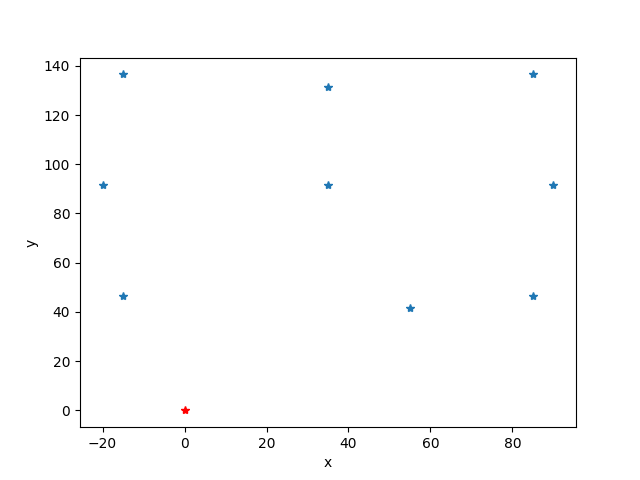

In [17]:
fiducial_locs = ct_nr.options.fiducial_locations

plt.figure(1).clear()
plt.plot(fiducial_locs[:, 0], fiducial_locs[:, 1], '*')
plt.plot(0, 0, 'r*')

plt.xlabel("x")
plt.ylabel("y")

plt.show()

In [22]:
ct_fiducial_locs = pd.read_excel(
    "/home/dlezcan1/data/Jacynthe-Needle/2023-05-31/ct_images/unpacked/results/2023-05-31/2023-05-31_09-21-38/ct_scan_results.xlsx",
    sheet_name="fiducial locations",
    index_col=None,
    header=None
).to_numpy()

pose = pd.read_excel(
    "/home/dlezcan1/data/Jacynthe-Needle/2023-05-31/ct_images/unpacked/results/2023-05-31/2023-05-31_09-21-38/ct_scan_results.xlsx",
    sheet_name="fiducial pose",
    index_col=None,
    header=None
).to_numpy()

ct_fiducial_locs, pose

(array([[102.9574776 , 206.10435453, 179.52236873],
        [102.53670395, 161.10716805, 175.80373881],
        [103.3836261 , 250.87362195, 172.8034195 ],
        [102.24650164, 154.72468615, 146.11447251],
        [102.2602833 , 204.27485935, 124.435508  ],
        [102.96856439, 244.25584756, 122.85563854],
        [101.39395345, 157.43003207,  76.10433348],
        [102.559739  , 247.15260148,  72.97294305],
        [101.69323705, 202.32110285,  69.82451365]]),
 array([[ 9.55920623e-03, -1.47731695e-02,  9.99845176e-01,
          1.03423970e+02],
        [-5.33673073e-02, -9.98473373e-01, -1.42426724e-02,
          2.95375601e+02],
        [ 9.98529194e-01, -5.32228961e-02, -1.03330172e-02,
          9.43584980e+01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]))

[0 2 1 3 5 4 7 6 8]
[[  0.    0.   -1.  101.1]
 [  0.    1.    0.  111.5]
 [  1.   -0.    0.   92.7]
 [  0.    0.    0.    1. ]]


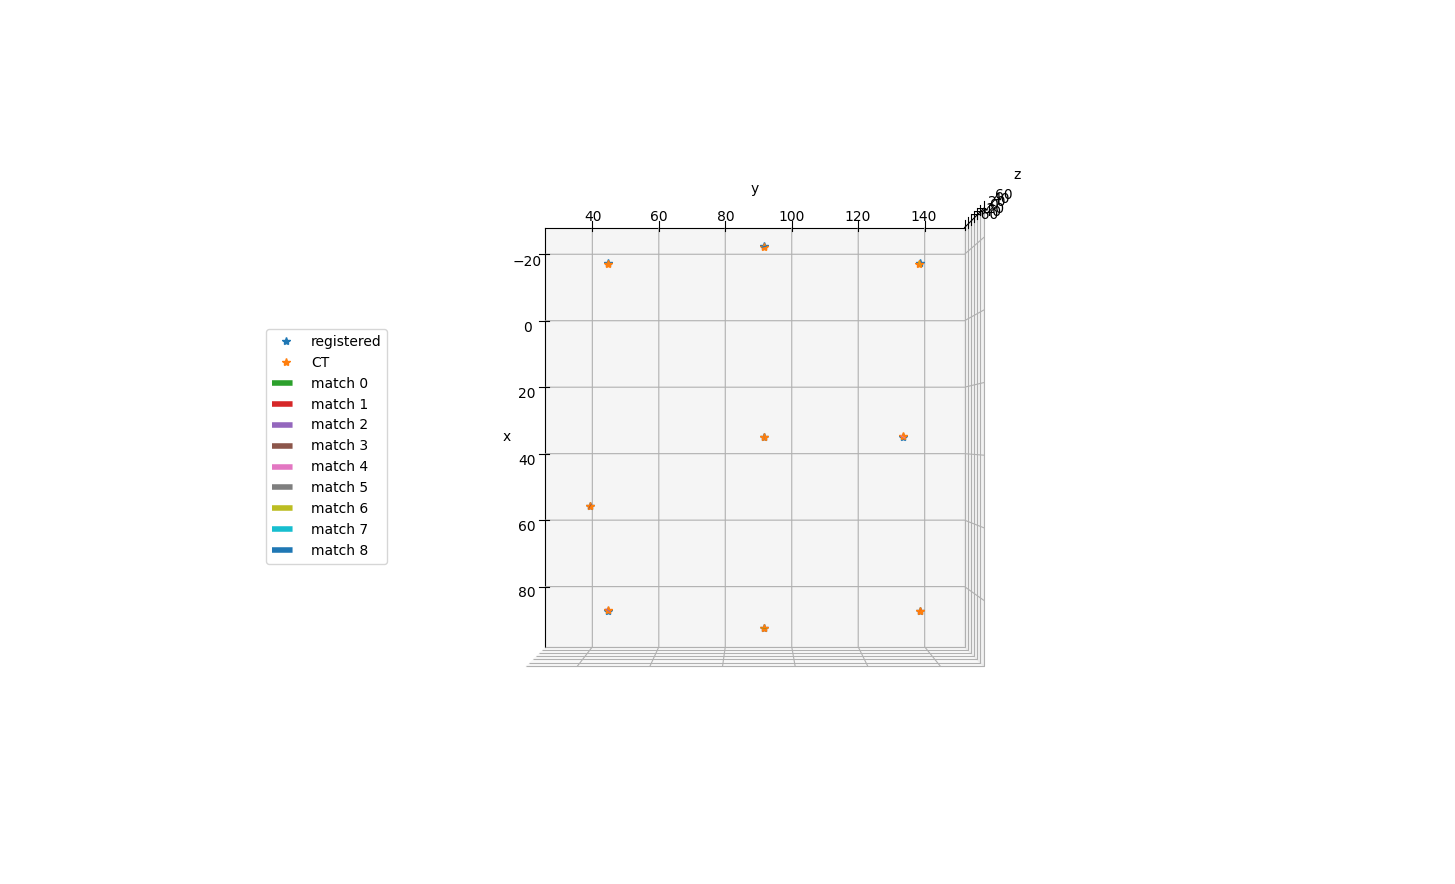

In [90]:
idxs = np.arange(fiducial_locs.shape[0]) # default

swaps = [
    ( 4, 5 ),
    (1, 2),
    (6, 7)
]

for i, j in swaps:
    idxs[i], idxs[j] = idxs[j], idxs[i]

print(idxs)

pose = point_cloud_registration(fiducial_locs, ct_fiducial_locs[idxs])
print(pose.round(1))

all_fid_locs = np.stack((fiducial_locs, transformSE3(ct_fiducial_locs[idxs], np.linalg.inv(pose))), axis=0)

fig = plt.figure(2, figsize=(6, 6))
fig.clear()
ax = fig.add_subplot(projection='3d')
ax.plot(all_fid_locs[0, :, 0], all_fid_locs[0, :, 1], all_fid_locs[0, :, 2], '*', label="registered")
ax.plot(all_fid_locs[1, :, 0], all_fid_locs[1, :, 1], all_fid_locs[1, :, 2], '*', label="CT")
for i in range(all_fid_locs.shape[1]):
    ax.plot(all_fid_locs[:, i, 0], all_fid_locs[:, i, 1], all_fid_locs[:, i, 2], '--', label=f"match {i}", linewidth=4)

plt.legend(loc='center left', borderaxespad=-10)

axisEqual3D(ax)
ax.view_init(90, 0)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

plt.show()

In [116]:
ct_fiducial_locs_std = ct_fiducial_locs[idxs]
print(ct_fiducial_locs_std.round(2))

ct_fiducial_locs[ct_fiducial_locs_std.shape[0]//2 + 1]


idx_ctr = np.argmin(np.linalg.norm(fiducial_locs - fiducial_locs.mean(axis=0), ord=2, axis=1))
centered_fid_locs = fiducial_locs - fiducial_locs[idx_ctr]
print(centered_fid_locs)
print(np.linalg.norm(centered_fid_locs, ord=1, axis=1))

[[102.96 206.1  179.52]
 [103.38 250.87 172.8 ]
 [102.54 161.11 175.8 ]
 [102.25 154.72 146.11]
 [102.97 244.26 122.86]
 [102.26 204.27 124.44]
 [102.56 247.15  72.97]
 [101.39 157.43  76.1 ]
 [101.69 202.32  69.82]]
[[ 55.   0.   0.]
 [ 50.  45.   0.]
 [ 50. -45.   0.]
 [ 20. -50.   0.]
 [  0.  40.   0.]
 [  0.   0.   0.]
 [-50.  45.   0.]
 [-50. -45.   0.]
 [-55.   0.   0.]]
[55. 95. 95. 70. 40.  0. 95. 95. 55.]


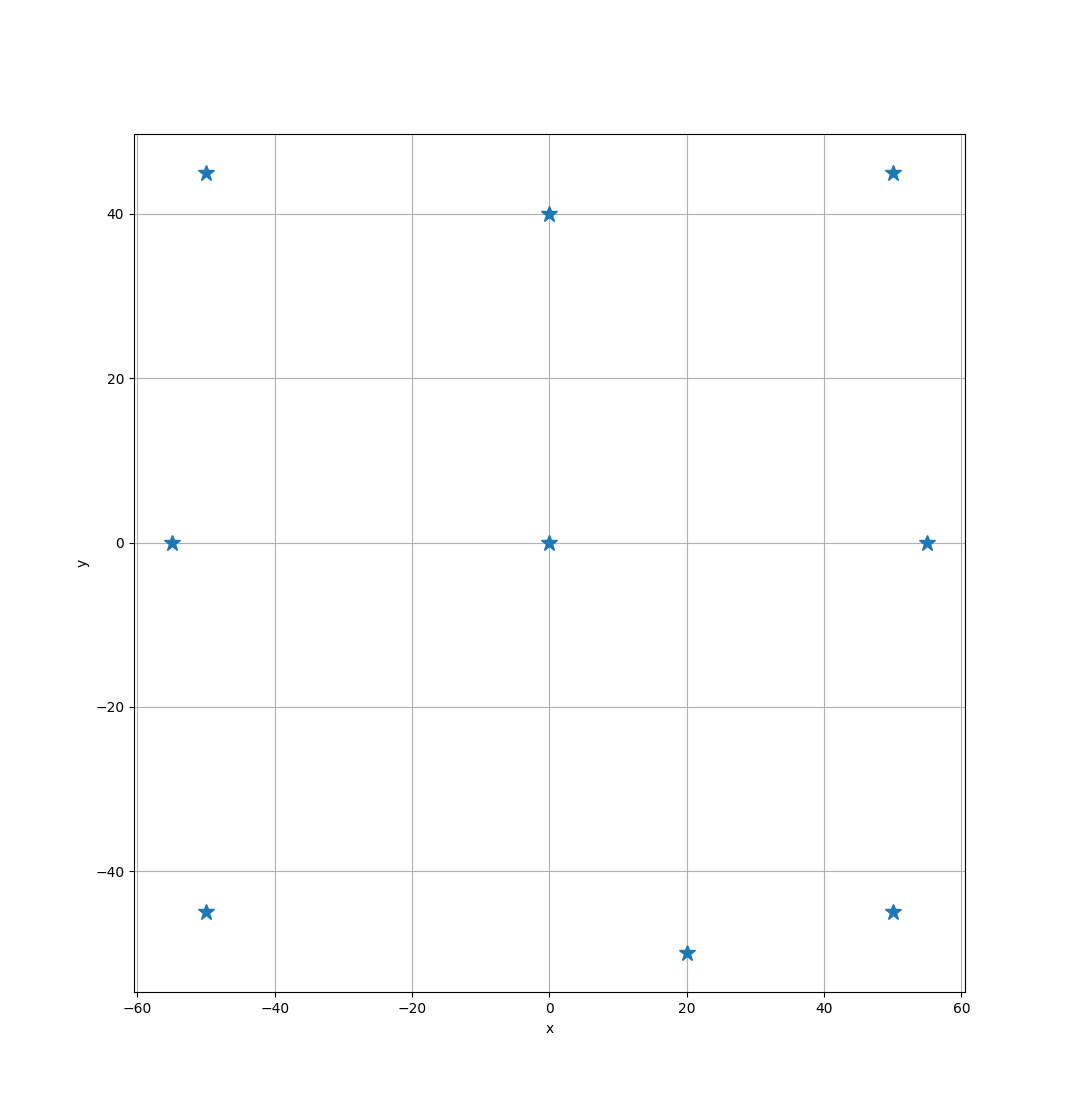

In [110]:
fig = plt.figure(3, figsize=(8, 8))
fig.clear()
ax = fig.add_subplot()
ax.plot(fiducial_locs[:, 0] - fiducial_locs[idx_ctr, 0], fiducial_locs[:, 1] - fiducial_locs[idx_ctr, 1], '*', markersize=12)
# for i in range(all_fid_locs.shape[1]):
#     ax.plot(all_fid_locs[:, i, 0], all_fid_locs[:, i, 1], '--', label=f"match {i}")
plt.grid()
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

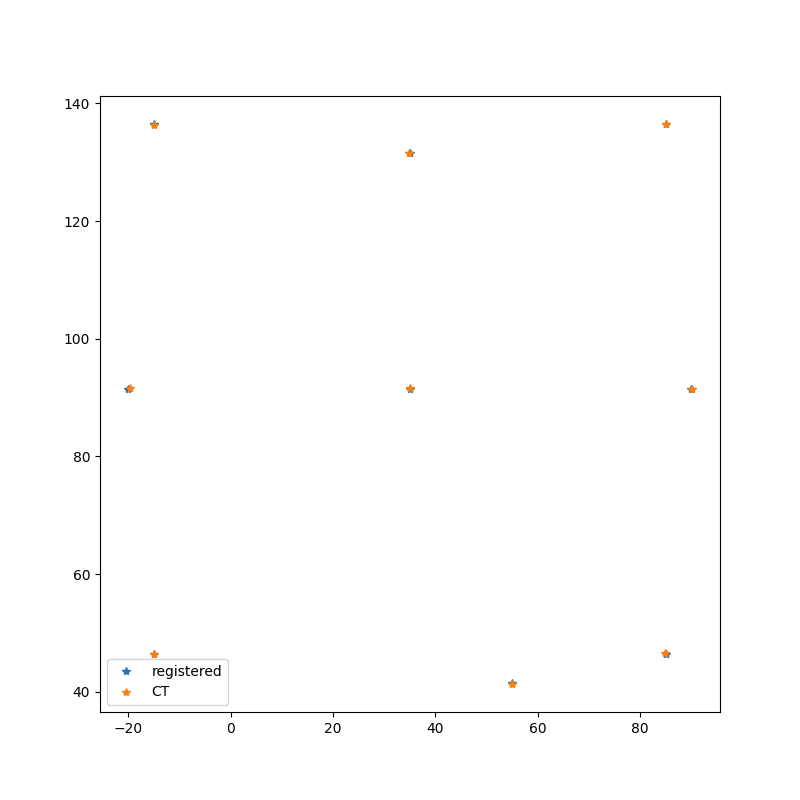

In [112]:
fig = plt.figure(4, figsize=(8, 8))
fig.clear()
ax = fig.add_subplot()
ax.plot(all_fid_locs[0, :, 0], all_fid_locs[0, :, 1], '*', label="registered")
ax.plot(all_fid_locs[1, :, 0], all_fid_locs[1, :, 1], '*', label="CT")
# for i in range(all_fid_locs.shape[1]):
#     ax.plot(all_fid_locs[:, i, 0], all_fid_locs[:, i, 1], '--', label=f"match {i}")


plt.legend(loc='best')
plt.show()

In [ ]:
# ct_nr.options.roi_needle.top_left[0] = 10
plt.close("all")
ret = reconstruct_needle(ct_nr)
ret.keys()

In [ ]:
lbl_needle_mask = ret['label_needle_mask']
lbl_sum = {
    lbl: np.sum(lbl_needle_mask == lbl) for lbl in range(1, np.unique(lbl_needle_mask).size)
}

print(lbl_needle_mask.dtype)

print(dict(sorted(lbl_sum.items(), key=lambda k_v: k_v[1], reverse=True)))

print(np.argmax([
    np.sum(lbl_needle_mask == lbl) for lbl in range(1, np.unique(lbl_needle_mask).size)
]) + 1)

In [ ]:
num_thresh = 500

plt.close("all")
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
for lbl, num in lbl_sum.items():
    if num < num_thresh:
        continue

    pts_lbl = np.argwhere(lbl_needle_mask == lbl)
    ax.scatter(pts_lbl[:, 0], pts_lbl[:, 1], pts_lbl[:,2], label=f"Label {lbl}: {num}")

ax.legend()

axisEqual3D(ax)
plt.show()

In [ ]:
lbl_conn = dict()
lbl_conn["None"] = skimage.measure.label(ret['needle_mask'], connectivity=None)
lbl_conn["1"]    = skimage.measure.label(ret['needle_mask'], connectivity=1)
lbl_conn["2"]    = skimage.measure.label(ret['needle_mask'], connectivity=2)

In [ ]:
for i, (key, lbl_mask) in enumerate(lbl_conn.items()):
    plt.figure(i+2)

    ax = plt.gcf().add_subplot(111, projection='3d')
    for val in np.unique(lbl_mask):
        if val == 0:
            continue

        pts_val = np.argwhere(lbl_mask == val).astype(np.float64)
        ax.scatter(pts_val[:, 0], pts_val[:, 1], pts_val[:,2])



    # for
    axisEqual3D(ax)
    ax.set_title(f"Connectivity: {key}")

    plt.show()

# for

In [ ]:
needle_pts = ret["needle_pts"]
print(needle_pts.shape)

idxs = np.argsort(needle_pts[:, 2])
needle_pts = needle_pts[idxs]

In [ ]:
L, _, s = arclength(needle_pts)
needle_interp_bspl = BSplineND.fit(s, needle_pts, order=3)

ds = 0.5
s_interp = np.arange(0, L, ds)
needle_interp_pts = needle_interp_bspl(s_interp)

In [ ]:
plt.close('all')
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

axes[0].plot(needle_pts[:, 2], needle_pts[:, 0], '-*', label="CT points")
axes[0].plot(needle_interp_pts[:, 2], needle_interp_pts[:, 0], '-*', label="CT points (interp.)")
axes[0].set_ylabel( "x (mm)" )

axes[1].plot(needle_pts[:, 2], needle_pts[:, 1], '-*', label="CT points")
axes[1].plot(needle_interp_pts[:, 2], needle_interp_pts[:, 1], '-*', label="CT points (interp.)")
axes[1].set_ylabel("y (mm)")
axes[1].set_xlabel("z (mm)")

axes[0].legend(loc="best")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(needle_pts[:, 0], needle_pts[:,1], needle_pts[:, 2], label='CT Points')
ax.plot(needle_interp_pts[:, 0], needle_interp_pts[:, 1], needle_interp_pts[:,2], label='CT points (interp.)')

axisEqual3D(ax)

ax.legend(loc='best')

plt.show()

In [ ]:
order = 5
polys = [sp.interpolate.BPoly(np.eye(order+1)[i].reshape(-1,1), [0,1]) for i in range(order+1) ]
x = np.arange(4, dtype=float)
x /= x.max()
A = np.stack(list(map(lambda p: p(x), polys)), axis=1)
y = np.arange(3*x.shape[0]).reshape(-1, 3)

c, res, rank, sig = np.linalg.lstsq(A, y, rcond=None)
print(c)
print()
print("A", "x", "y", "c")
print(A.shape, x.shape, y.shape, c.shape)

print()
print(A)

In [ ]:
sp.interpolate.BPoly([[2]], [0, 1]).__call__(np.arange(4,dtype=float)/4)

In [ ]:
L - np.arange(0, L, ds)

In [ ]:
fiducial_base_locs = ret["fiducial_pts"] - ret["fiducial_pts"][0]
print(fiducial_base_locs)

In [ ]:
A = np.random.randn(20, 3)
tf = np.eye(4)

tf[:3, :3] = sp.spatial.transform.Rotation.from_rotvec(np.random.randn(3)).as_matrix()

idx_perm = np.random.permutation(A.shape[0])
B = A[idx_perm] @ tf[:3, :3].T + tf[:3, -1].T

print(tf)

In [ ]:
Av = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(A))
Bv = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(B))

In [ ]:
result = o3d.pipelines.registration.registration_icp(
    Av, 
    Bv,
    1
)

result.transformation.round(3)